In [1]:
import os
import time
import uuid
import cv2

import pandas as pd
import matplotlib.image as mpimg
import glob

import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
#Comprobar que esté configurada correctamente la GPU con CUDA y cudNN
print(tf.test.is_built_with_cuda())
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

True


In [3]:
#RESIZE_SIZE = 250
#CROP_SIZE= 224
RESIZE_SIZE = 110
CROP_SIZE= 96

In [50]:
#BATCH_SIZE = 8
BATCH_SIZE = 1
num_train_img = 3462
num_test_img = 770
#num_train_img = 3462
#num_test_img = 770

<h2>Leer datos</h2>

In [5]:
path_to_json = 'Dataset/sirven/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
#print(json_files)

In [6]:
puntos_orgT=[]
name_puntos_orgT=[]
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        data = json.load(json_file)
        #print( data['imagePath'][3:15])
        mi_vector = []
        
        for shape in data['shapes']:
            mi_vector.append(shape['points'][0])

        labels = []
        for label in data['shapes']:
            labels.append(label['label'])

        puntos_orgU=[None] * 16
        j=0
        for i in labels:
    
            puntos_orgU[int(i)-1]=mi_vector[j]
           # print(int(i),":",puntos_orgU[int(i)-1])
            j=j+1
        puntos_orgT.append(puntos_orgU)
        name_puntos_orgT.append(data['imagePath'])
points = np.array(puntos_orgT)
names = np.array(name_puntos_orgT)
#print(names[0],points[0])    

In [7]:
print(points.shape)

(1000, 16, 2)


In [8]:
print(names.shape)

(1000,)


In [9]:
#Entra un numpy array de imagen y keypoints
def transform_fn(img, keypoints):   
    #if alfa color get rid of it
    if(img.shape[2]==4):
        img = img[:,:,0:3]
    
    #reescalar la imagen dejando el lado más corto en 250 sin perder el aspect ratio
    resize_size = RESIZE_SIZE
    h, w = img.shape[:2]
        
    if h > w:
        new_h, new_w = int(resize_size * h / w), resize_size
    else:
        new_h, new_w = resize_size, int(resize_size * w / h)
    
    img = cv2.resize(img, (new_w, new_h))
    
    keypoints = keypoints * [new_w / w, new_h / h]
    
    
    #random crop a la imagen para dejarla de 224x224 px
    crop_size = CROP_SIZE
    h, w = img.shape[:2]
    new_h, new_w = crop_size, crop_size
    
    top = np.random.randint(0, h - new_h )
    left = np.random.randint(0, w - new_w )
   

    img = img[top: top + new_h, left: left + new_w]
    keypoints = keypoints - [left, top]
    
    #convertir a escala de grises y normalizar
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img=  img/255.0
    keypoints = (keypoints-50.0)/25.0
    
    
    return img, keypoints

In [10]:
#Entra la ruta de imágenes y el vector de keypoints en formato numpy
def transform_all(route, keypoints, label_names):
    image_array_list = []
    keypoints_array_list = []
    
    for idx, image_name in enumerate(label_names):
    #    print(image_name)
        img_route = os.path.join(route, image_name)
        img = cv2.imread(img_route)
        try:
            new_image, new_keypoints = transform_fn(img, keypoints[idx])
        except:
            print("Error at image:", idx)
        
        
#        im = Image.fromarray(new_image)
#        im.save("newdata/" + image_name,"TIFF")
        image_array_list.append(new_image)
        keypoints_array_list.append(new_keypoints)
    
    #Organiza alfabeticamente y lee imágenes
#    filenames = glob.glob(route)
#    print("filenames",filenames)
#    filenames.sort()
#    image_list = [cv2.imread(img) for img in filenames]
    #transforma imágenes a numpy y aplica rescale, random_crop y normalize
#    for idx, img in enumerate(image_list):
#        image, keypoints[idx] = transform_fn(img, keypoints[idx])
#        image_array_list.append(image)
        
  #  image_array_list = [transform_image(np.array(img))[0] for img in image_list]

    #junta todo en un arreglo de imágenes transformadas
    final_image_array = np.stack(image_array_list)
    final_keypoints_array = np.stack(keypoints_array_list)
    
    return final_image_array, final_keypoints_array

In [11]:
#transformed_images, transformed_keypoints = transform_all("Dataset/sirven", points, names)
train_images, train_keypoints = transform_all("Dataset/sirven", points[:700], names[:700])
test_images, test_keypoints = transform_all("Dataset/sirven", points[700:850], names[700:850])
val_images, val_keypoints = transform_all("Dataset/sirven", points[850:], names[850:])


In [12]:
print(train_images.dtype, train_images.shape)
print(train_keypoints.dtype, train_keypoints.shape)

float64 (700, 96, 96)
float64 (700, 16, 2)


In [13]:
print(test_images.dtype, test_images.shape)
print(test_keypoints.dtype, test_keypoints.shape)

float64 (150, 96, 96)
float64 (150, 16, 2)


In [14]:
print(val_images.dtype, val_images.shape)
print(val_keypoints.dtype, val_keypoints.shape)

float64 (150, 96, 96)
float64 (150, 16, 2)


In [15]:
#EXPERIMENTAL
def gen_series(images, keypoints):
#    print(len(images))
#    print(images[0])
    stop = len(images)
    i = 0
    while i < stop:
        yield images[i], keypoints[i]
        i += 1

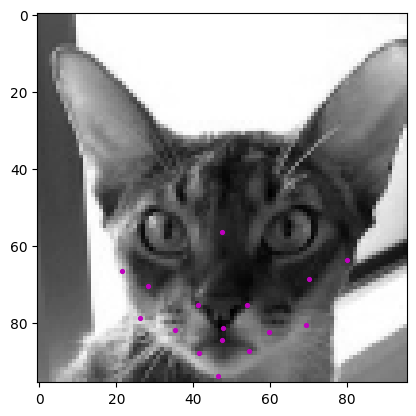

In [16]:
n = 70
plt.imshow(train_images[n], cmap='gray')
#print(test_keypoints[n])
plt.scatter(train_keypoints[n][:, 0]*25+50, train_keypoints[n][:, 1]*25+50, s=30, marker='.', c='m')

In [17]:
train = tf.data.Dataset.from_generator(
    gen_series,
    args=[train_images , train_keypoints],
    output_types=(tf.float64, tf.float64),
    output_shapes=([CROP_SIZE,CROP_SIZE], [16, 2])
)

train = train.shuffle(700)
train = train.batch(BATCH_SIZE)
train = train.prefetch(tf.data.AUTOTUNE)

In [18]:
test = tf.data.Dataset.from_generator(
    gen_series,
    args=[test_images , test_keypoints],
    output_types=(tf.float64, tf.float64),
    output_shapes=([CROP_SIZE,CROP_SIZE], [16, 2])
)


test = test.shuffle(150)
test = test.batch(BATCH_SIZE)
test = test.prefetch(tf.data.AUTOTUNE)

In [19]:
val = tf.data.Dataset.from_generator(
    gen_series,
    args=[val_images , val_keypoints],
    output_types=(tf.float64, tf.float64),
    output_shapes=([CROP_SIZE,CROP_SIZE], [16, 2])
)


val = val.shuffle(150)
val = val.batch(BATCH_SIZE)
val = val.prefetch(tf.data.AUTOTUNE)

(8, 96, 96)


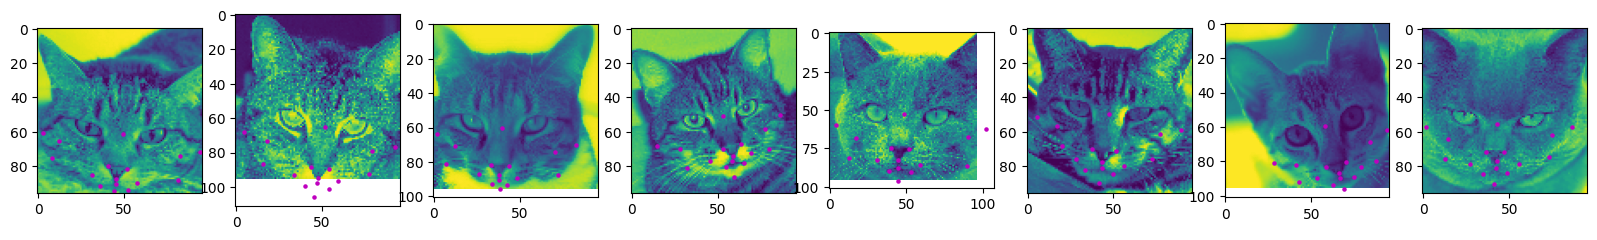

In [20]:
res = val.as_numpy_iterator().next()
print(res[0].shape)
if BATCH_SIZE == 1:
    sample_image = res[0][0]
    sample_coords = res[1][0]
    
    key_pts = sample_coords*25 + 50
    
    plt.imshow(sample_image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
else:
    fig, ax = plt.subplots(ncols=BATCH_SIZE, figsize=(20,20))
    for idx in range(BATCH_SIZE): 
        sample_image = res[0][idx]
        sample_coords = res[1][idx]

        key_pts = sample_coords*25 + 50

        ax[idx].imshow(sample_image)
        ax[idx].scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

<h2>Build a model</h2>

<h2>Inception model mixed_3</h2>

In [21]:
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout, Dense, Flatten
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import MaxPooling2D

In [22]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model = InceptionV3(include_top=False, weights=None, input_shape=(CROP_SIZE,CROP_SIZE,1))

In [23]:
# Create the feature extraction model
inception_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('mixed3').output)

In [24]:
model = Sequential([
    Input(shape=(CROP_SIZE,CROP_SIZE,1), dtype=np.float64), 
    inception_model,
    Conv2D(256, 2,  activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(500, activation="relu"),
#    Dropout(0.5),
    Dense(500,  activation="relu"),
#    Dropout(0.5),
    Dense(32),
    Reshape((16,2))
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 768)         2146400   
                                                                 
 conv2d_188 (Conv2D)         (None, 4, 4, 256)         786688    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 500)               512500    
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                        

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [27]:
model.compile(optimizer, loss)

In [28]:
hist = model.fit(train, epochs=400, validation_data=val)

Epoch 1/400
88/88 [==============================] - 9s 39ms/step - loss: 0.2259 - val_loss: 0.4113
Epoch 2/400
88/88 [==============================] - 2s 22ms/step - loss: 0.0984 - val_loss: 0.4080
Epoch 3/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0787 - val_loss: 0.2598
Epoch 4/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0530 - val_loss: 0.1716
Epoch 5/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0390 - val_loss: 0.1217
Epoch 6/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0288 - val_loss: 0.0925
Epoch 7/400
88/88 [==============================] - 2s 22ms/step - loss: 0.0244 - val_loss: 0.0598
Epoch 8/400
88/88 [==============================] - 2s 22ms/step - loss: 0.0200 - val_loss: 0.0581
Epoch 9/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0181 - val_loss: 0.0474
Epoch 10/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0162 - val_loss: 0.0491

88/88 [==============================] - 2s 23ms/step - loss: 6.8906e-04 - val_loss: 0.0349
Epoch 162/400
88/88 [==============================] - 2s 22ms/step - loss: 7.4615e-04 - val_loss: 0.0336
Epoch 163/400
88/88 [==============================] - 2s 22ms/step - loss: 7.2398e-04 - val_loss: 0.0342
Epoch 164/400
88/88 [==============================] - 2s 22ms/step - loss: 6.5213e-04 - val_loss: 0.0334
Epoch 165/400
88/88 [==============================] - 2s 22ms/step - loss: 5.9669e-04 - val_loss: 0.0338
Epoch 166/400
88/88 [==============================] - 2s 24ms/step - loss: 6.2554e-04 - val_loss: 0.0339
Epoch 167/400
88/88 [==============================] - 2s 22ms/step - loss: 5.4398e-04 - val_loss: 0.0343
Epoch 168/400
88/88 [==============================] - 2s 23ms/step - loss: 5.7045e-04 - val_loss: 0.0337
Epoch 169/400
88/88 [==============================] - 2s 23ms/step - loss: 6.2568e-04 - val_loss: 0.0343
Epoch 170/400
88/88 [==============================] - 2s 23

88/88 [==============================] - 2s 24ms/step - loss: 2.1857e-04 - val_loss: 0.0339
Epoch 316/400
88/88 [==============================] - 2s 24ms/step - loss: 2.2258e-04 - val_loss: 0.0338
Epoch 317/400
88/88 [==============================] - 2s 23ms/step - loss: 2.0114e-04 - val_loss: 0.0334
Epoch 318/400
88/88 [==============================] - 2s 24ms/step - loss: 2.0298e-04 - val_loss: 0.0338
Epoch 319/400
88/88 [==============================] - 2s 24ms/step - loss: 2.0670e-04 - val_loss: 0.0338
Epoch 320/400
88/88 [==============================] - 2s 24ms/step - loss: 2.1665e-04 - val_loss: 0.0339
Epoch 321/400
88/88 [==============================] - 2s 23ms/step - loss: 1.9806e-04 - val_loss: 0.0336
Epoch 322/400
88/88 [==============================] - 2s 24ms/step - loss: 2.0845e-04 - val_loss: 0.0335
Epoch 323/400
88/88 [==============================] - 2s 23ms/step - loss: 1.9362e-04 - val_loss: 0.0338
Epoch 324/400
88/88 [==============================] - 2s 23

<h3>Test del Inception model mixed_3</h3>

1/1 [==============================] - 0s 22ms/step


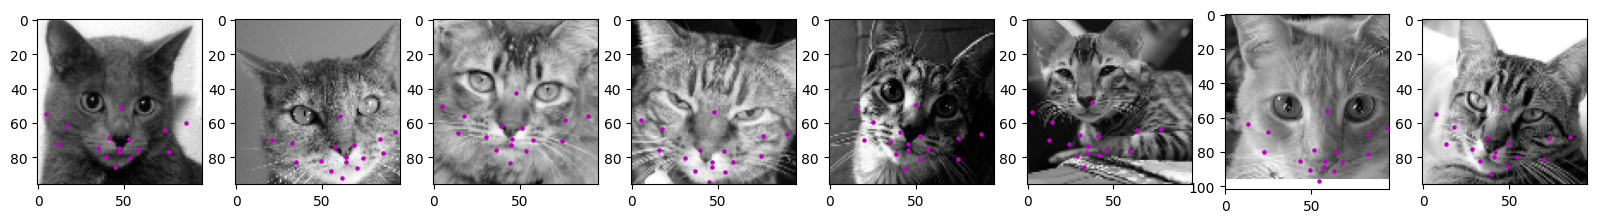

In [30]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
if BATCH_SIZE == 1:
    sample_image = test_sample[0][0]
    sample_coords = yhat[0]
    
    key_pts = sample_coords*25 + 50
    
    plt.imshow(sample_image, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
else:
    fig, ax = plt.subplots(ncols=BATCH_SIZE, figsize=(20,20))
    for idx in range(BATCH_SIZE): 
        sample_image = test_sample[0][idx]
        sample_coords = yhat[idx]

        key_pts = sample_coords*25 + 50

        ax[idx].imshow(sample_image, cmap='gray')
        ax[idx].scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [31]:
# Save the entire model as a `.keras` zip archive.
model.save('inception_400_epoch_batch_8_no_dropout.keras')

In [32]:
import pickle
with open("hist_loss_mixed_3", "wb") as fp:
    pickle.dump(hist.history['loss'], fp)

with open("hist_val_loss_mixed_3", "wb") as fp:
    pickle.dump(hist.history['val_loss'], fp)

In [35]:
#model = tf.keras.models.load_model('inception_400_epoch_batch_8_no_dropout.keras')

#with open("hist_loss_mixed_3", "rb") as fp:   # Unpickling
#    loss = pickle.load(fp)
#with open("hist_val_loss_mixed_3", "rb") as fp:   # Unpickling
#    val_loss = pickle.load(fp)

<h2>Inception model mixed_3 with dropout</h2>

In [21]:
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout, Dense, Flatten
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import MaxPooling2D

In [22]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model = InceptionV3(include_top=False, weights=None, input_shape=(CROP_SIZE,CROP_SIZE,1))

In [23]:
# Create the feature extraction model
inception_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('mixed3').output)

In [24]:
model = Sequential([
    Input(shape=(CROP_SIZE,CROP_SIZE,1), dtype=np.float64), 
    inception_model,
    Conv2D(256, 2,  activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(500, activation="relu"),
    Dropout(0.5),
    Dense(500,  activation="relu"),
    Dropout(0.5),
    Dense(32),
    Reshape((16,2))
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 768)         2146400   
                                                                 
 conv2d_188 (Conv2D)         (None, 4, 4, 256)         786688    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 500)               512500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                        

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [27]:
model.compile(optimizer, loss)

In [28]:
hist = model.fit(train, epochs=400, validation_data=val)

Epoch 1/400
88/88 [==============================] - 9s 39ms/step - loss: 0.4390 - val_loss: 0.4553
Epoch 2/400
88/88 [==============================] - 2s 23ms/step - loss: 0.1950 - val_loss: 0.1328
Epoch 3/400
88/88 [==============================] - 2s 24ms/step - loss: 0.1609 - val_loss: 0.3698
Epoch 4/400
88/88 [==============================] - 2s 23ms/step - loss: 0.1402 - val_loss: 0.1405
Epoch 5/400
88/88 [==============================] - 2s 23ms/step - loss: 0.1285 - val_loss: 0.2044
Epoch 6/400
88/88 [==============================] - 2s 23ms/step - loss: 0.1143 - val_loss: 0.1569
Epoch 7/400
88/88 [==============================] - 2s 23ms/step - loss: 0.1069 - val_loss: 0.1280
Epoch 8/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0894 - val_loss: 0.0870
Epoch 9/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0833 - val_loss: 0.0927
Epoch 10/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0723 - val_loss: 0.0832

88/88 [==============================] - 2s 23ms/step - loss: 0.0220 - val_loss: 0.0426
Epoch 83/400
88/88 [==============================] - 2s 22ms/step - loss: 0.0215 - val_loss: 0.0436
Epoch 84/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0215 - val_loss: 0.0487
Epoch 85/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0220 - val_loss: 0.0461
Epoch 86/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0210 - val_loss: 0.0471
Epoch 87/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0205 - val_loss: 0.0431
Epoch 88/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0204 - val_loss: 0.0421
Epoch 89/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0199 - val_loss: 0.0461
Epoch 90/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0199 - val_loss: 0.0451
Epoch 91/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0202 - val_loss: 0.0443
Epo

88/88 [==============================] - 2s 23ms/step - loss: 0.0168 - val_loss: 0.0401
Epoch 163/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0165 - val_loss: 0.0398
Epoch 164/400
88/88 [==============================] - 2s 22ms/step - loss: 0.0172 - val_loss: 0.0391
Epoch 165/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0173 - val_loss: 0.0401
Epoch 166/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0177 - val_loss: 0.0408
Epoch 167/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0167 - val_loss: 0.0408
Epoch 168/400
88/88 [==============================] - 2s 22ms/step - loss: 0.0162 - val_loss: 0.0408
Epoch 169/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0167 - val_loss: 0.0422
Epoch 170/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0165 - val_loss: 0.0415
Epoch 171/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0168 - val_loss: 0

88/88 [==============================] - 2s 24ms/step - loss: 0.0146 - val_loss: 0.0379
Epoch 243/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0143 - val_loss: 0.0392
Epoch 244/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0140 - val_loss: 0.0383
Epoch 245/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0141 - val_loss: 0.0391
Epoch 246/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0143 - val_loss: 0.0389
Epoch 247/400
88/88 [==============================] - 2s 23ms/step - loss: 0.0137 - val_loss: 0.0395
Epoch 248/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0143 - val_loss: 0.0392
Epoch 249/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0145 - val_loss: 0.0367
Epoch 250/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0141 - val_loss: 0.0388
Epoch 251/400
88/88 [==============================] - 2s 25ms/step - loss: 0.0145 - val_loss: 0

88/88 [==============================] - 2s 24ms/step - loss: 0.0135 - val_loss: 0.0380
Epoch 323/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0132 - val_loss: 0.0385
Epoch 324/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0132 - val_loss: 0.0392
Epoch 325/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0128 - val_loss: 0.0392
Epoch 326/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0130 - val_loss: 0.0381
Epoch 327/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0137 - val_loss: 0.0381
Epoch 328/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0131 - val_loss: 0.0374
Epoch 329/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0133 - val_loss: 0.0385
Epoch 330/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0135 - val_loss: 0.0374
Epoch 331/400
88/88 [==============================] - 2s 24ms/step - loss: 0.0127 - val_loss: 0

<h3>Test del Inception model mixed_3 with dropout</h3>

1/1 [==============================] - 0s 368ms/step


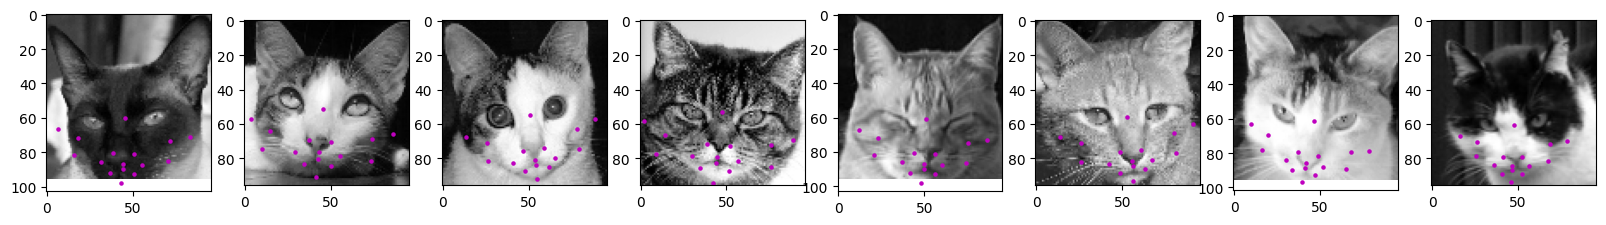

In [29]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
if BATCH_SIZE == 1:
    sample_image = test_sample[0][0]
    sample_coords = yhat[0]
    
    key_pts = sample_coords*25 + 50
    
    plt.imshow(sample_image, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
else:
    fig, ax = plt.subplots(ncols=BATCH_SIZE, figsize=(20,20))
    for idx in range(BATCH_SIZE): 
        sample_image = test_sample[0][idx]
        sample_coords = yhat[idx]

        key_pts = sample_coords*25 + 50

        ax[idx].imshow(sample_image, cmap='gray')
        ax[idx].scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [30]:
# Save the entire model as a `.keras` zip archive.
model.save('inception_400_epoch_batch_8_with_dropout.keras')

In [31]:
import pickle
with open("hist_loss_mixed_3_with_dropout", "wb") as fp:
    pickle.dump(hist.history['loss'], fp)

with open("hist_val_loss_mixed_with_dropout", "wb") as fp:
    pickle.dump(hist.history['val_loss'], fp)

In [ ]:
#model = tf.keras.models.load_model('inception_400_epoch_batch_8_no_dropout.keras')

#with open("hist_loss_mixed_3_with_dropout", "rb") as fp:   # Unpickling
#    loss = pickle.load(fp)
#with open("hist_val_loss_mixed__with_dropout", "rb") as fp:   # Unpickling
#    val_loss = pickle.load(fp)

<h2>Inception model mixed_5</h2>

In [21]:
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout, Dense, Flatten
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import MaxPooling2D

In [22]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model = InceptionV3(include_top=False, weights=None, input_shape=(CROP_SIZE,CROP_SIZE,1))

In [23]:
# Create the feature extraction model
inception_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('mixed5').output)

In [24]:
model = Sequential([
    Input(shape=(CROP_SIZE,CROP_SIZE,1), dtype=np.float64), 
    inception_model,
    Conv2D(256, 2,  activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(500, activation="relu"),
#    Dropout(0.5),
    Dense(500,  activation="relu"),
#    Dropout(0.5),
    Dense(32),
    Reshape((16,2))
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 768)         5138080   
                                                                 
 conv2d_188 (Conv2D)         (None, 4, 4, 256)         786688    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 500)               512500    
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                        

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [27]:
model.compile(optimizer, loss)

In [28]:
hist = model.fit(train, epochs=400, validation_data=val)

Epoch 1/400
88/88 [==============================] - 11s 52ms/step - loss: 0.1915 - val_loss: 0.3245
Epoch 2/400
88/88 [==============================] - 3s 33ms/step - loss: 0.1126 - val_loss: 0.1527
Epoch 3/400
88/88 [==============================] - 3s 32ms/step - loss: 0.0915 - val_loss: 0.1441
Epoch 4/400
88/88 [==============================] - 3s 32ms/step - loss: 0.0610 - val_loss: 0.1058
Epoch 5/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0400 - val_loss: 0.0800
Epoch 6/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0333 - val_loss: 0.0658
Epoch 7/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0277 - val_loss: 0.0509
Epoch 8/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0227 - val_loss: 0.0452
Epoch 9/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0208 - val_loss: 0.0523
Epoch 10/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0217 - val_loss: 0.044

88/88 [==============================] - 3s 32ms/step - loss: 0.0025 - val_loss: 0.0351
Epoch 83/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0021 - val_loss: 0.0341
Epoch 84/400
88/88 [==============================] - 3s 32ms/step - loss: 0.0017 - val_loss: 0.0339
Epoch 85/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0015 - val_loss: 0.0340
Epoch 86/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0014 - val_loss: 0.0337
Epoch 87/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0014 - val_loss: 0.0334
Epoch 88/400
88/88 [==============================] - 3s 32ms/step - loss: 0.0013 - val_loss: 0.0343
Epoch 89/400
88/88 [==============================] - 3s 32ms/step - loss: 0.0014 - val_loss: 0.0339
Epoch 90/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0014 - val_loss: 0.0339
Epoch 91/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0013 - val_loss: 0.0330
Epo

88/88 [==============================] - 3s 35ms/step - loss: 6.1803e-04 - val_loss: 0.0331
Epoch 162/400
88/88 [==============================] - 3s 35ms/step - loss: 6.4391e-04 - val_loss: 0.0328
Epoch 163/400
88/88 [==============================] - 3s 35ms/step - loss: 6.3432e-04 - val_loss: 0.0329
Epoch 164/400
88/88 [==============================] - 3s 35ms/step - loss: 5.5939e-04 - val_loss: 0.0337
Epoch 165/400
88/88 [==============================] - 3s 36ms/step - loss: 5.5641e-04 - val_loss: 0.0329
Epoch 166/400
88/88 [==============================] - 3s 34ms/step - loss: 5.4388e-04 - val_loss: 0.0341
Epoch 167/400
88/88 [==============================] - 3s 38ms/step - loss: 5.3685e-04 - val_loss: 0.0334
Epoch 168/400
88/88 [==============================] - 3s 35ms/step - loss: 5.2077e-04 - val_loss: 0.0335
Epoch 169/400
88/88 [==============================] - 3s 36ms/step - loss: 5.1511e-04 - val_loss: 0.0334
Epoch 170/400
88/88 [==============================] - 3s 36

88/88 [==============================] - 3s 34ms/step - loss: 2.9828e-04 - val_loss: 0.0328
Epoch 239/400
88/88 [==============================] - 3s 34ms/step - loss: 2.8339e-04 - val_loss: 0.0329
Epoch 240/400
88/88 [==============================] - 3s 35ms/step - loss: 2.7595e-04 - val_loss: 0.0329
Epoch 241/400
88/88 [==============================] - 3s 35ms/step - loss: 2.6833e-04 - val_loss: 0.0329
Epoch 242/400
88/88 [==============================] - 3s 33ms/step - loss: 2.6833e-04 - val_loss: 0.0332
Epoch 243/400
88/88 [==============================] - 3s 37ms/step - loss: 2.8075e-04 - val_loss: 0.0326
Epoch 244/400
88/88 [==============================] - 3s 36ms/step - loss: 2.8955e-04 - val_loss: 0.0328
Epoch 245/400
88/88 [==============================] - 3s 34ms/step - loss: 2.9110e-04 - val_loss: 0.0330
Epoch 246/400
88/88 [==============================] - 3s 33ms/step - loss: 2.8656e-04 - val_loss: 0.0325
Epoch 247/400
88/88 [==============================] - 3s 34

88/88 [==============================] - 3s 33ms/step - loss: 1.9046e-04 - val_loss: 0.0332
Epoch 316/400
88/88 [==============================] - 3s 34ms/step - loss: 2.0400e-04 - val_loss: 0.0330
Epoch 317/400
88/88 [==============================] - 3s 33ms/step - loss: 1.9877e-04 - val_loss: 0.0329
Epoch 318/400
88/88 [==============================] - 3s 34ms/step - loss: 1.9377e-04 - val_loss: 0.0333
Epoch 319/400
88/88 [==============================] - 3s 34ms/step - loss: 1.8890e-04 - val_loss: 0.0332
Epoch 320/400
88/88 [==============================] - 3s 33ms/step - loss: 1.9599e-04 - val_loss: 0.0334
Epoch 321/400
88/88 [==============================] - 3s 33ms/step - loss: 1.7408e-04 - val_loss: 0.0330
Epoch 322/400
88/88 [==============================] - 3s 34ms/step - loss: 1.7890e-04 - val_loss: 0.0332
Epoch 323/400
88/88 [==============================] - 3s 33ms/step - loss: 1.7752e-04 - val_loss: 0.0331
Epoch 324/400
88/88 [==============================] - 3s 33

88/88 [==============================] - 3s 33ms/step - loss: 1.2991e-04 - val_loss: 0.0331
Epoch 393/400
88/88 [==============================] - 3s 33ms/step - loss: 1.2287e-04 - val_loss: 0.0330
Epoch 394/400
88/88 [==============================] - 3s 32ms/step - loss: 1.3166e-04 - val_loss: 0.0329
Epoch 395/400
88/88 [==============================] - 3s 33ms/step - loss: 1.3247e-04 - val_loss: 0.0330
Epoch 396/400
88/88 [==============================] - 3s 33ms/step - loss: 1.2509e-04 - val_loss: 0.0329
Epoch 397/400
88/88 [==============================] - 3s 32ms/step - loss: 1.2756e-04 - val_loss: 0.0328
Epoch 398/400
88/88 [==============================] - 3s 32ms/step - loss: 1.2300e-04 - val_loss: 0.0327
Epoch 399/400
88/88 [==============================] - 3s 32ms/step - loss: 1.1727e-04 - val_loss: 0.0331
Epoch 400/400
88/88 [==============================] - 3s 33ms/step - loss: 1.1749e-04 - val_loss: 0.0330


<h3>Test del Inception model mixed_5</h3>

1/1 [==============================] - 0s 30ms/step


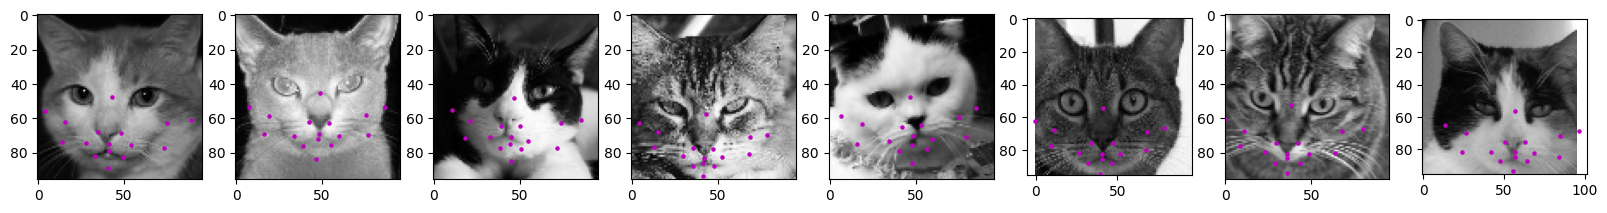

In [34]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
if BATCH_SIZE == 1:
    sample_image = test_sample[0][0]
    sample_coords = yhat[0]
    
    key_pts = sample_coords*25 + 50
    
    plt.imshow(sample_image, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
else:
    fig, ax = plt.subplots(ncols=BATCH_SIZE, figsize=(20,20))
    for idx in range(BATCH_SIZE): 
        sample_image = test_sample[0][idx]
        sample_coords = yhat[idx]

        key_pts = sample_coords*25 + 50

        ax[idx].imshow(sample_image, cmap='gray')
        ax[idx].scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [30]:
# Save the entire model as a `.keras` zip archive.
model.save('mixed_5_400_epoch_batch_8_no_dropout.keras')

In [31]:
import pickle
with open("hist_loss_mixed_5", "wb") as fp:
    pickle.dump(hist.history['loss'], fp)

with open("hist_val_loss_mixed_5", "wb") as fp:
    pickle.dump(hist.history['val_loss'], fp)

In [32]:
#model = tf.keras.models.load_model('mixed_5_400_epoch_batch_8_no_dropout.keras')

#with open("hist_loss_mixed_5", "rb") as fp:   # Unpickling
#    loss = pickle.load(fp)
#with open("hist_val_loss_mixed_5", "rb") as fp:   # Unpickling
#    val_loss = pickle.load(fp)

<h2>Inception model mixed_5 with dropout</h2>

In [21]:
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout, Dense, Flatten
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import MaxPooling2D

In [22]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
base_model = InceptionV3(include_top=False, weights=None, input_shape=(CROP_SIZE,CROP_SIZE,1))

In [23]:
# Create the feature extraction model
inception_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('mixed5').output)

In [24]:
model = Sequential([
    Input(shape=(CROP_SIZE,CROP_SIZE,1), dtype=np.float64), 
    inception_model,
    Conv2D(256, 2,  activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(500, activation="relu"),
    Dropout(0.5),
    Dense(500,  activation="relu"),
    Dropout(0.5),
    Dense(32),
    Reshape((16,2))
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 768)         5138080   
                                                                 
 conv2d_188 (Conv2D)         (None, 4, 4, 256)         786688    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 500)               512500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                        

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [27]:
model.compile(optimizer, loss)

In [28]:
hist = model.fit(train, epochs=400, validation_data=val)

Epoch 1/400
88/88 [==============================] - 11s 55ms/step - loss: 0.3661 - val_loss: 0.4987
Epoch 2/400
88/88 [==============================] - 3s 36ms/step - loss: 0.1936 - val_loss: 0.3180
Epoch 3/400
88/88 [==============================] - 3s 34ms/step - loss: 0.1726 - val_loss: 0.1360
Epoch 4/400
88/88 [==============================] - 3s 34ms/step - loss: 0.1483 - val_loss: 0.1308
Epoch 5/400
88/88 [==============================] - 3s 34ms/step - loss: 0.1332 - val_loss: 0.1351
Epoch 6/400
88/88 [==============================] - 3s 33ms/step - loss: 0.1167 - val_loss: 0.1449
Epoch 7/400
88/88 [==============================] - 3s 34ms/step - loss: 0.1090 - val_loss: 0.1043
Epoch 8/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0989 - val_loss: 0.1025
Epoch 9/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0880 - val_loss: 0.0771
Epoch 10/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0762 - val_loss: 0.077

88/88 [==============================] - 3s 33ms/step - loss: 0.0185 - val_loss: 0.0351
Epoch 83/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0181 - val_loss: 0.0362
Epoch 84/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0181 - val_loss: 0.0362
Epoch 85/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0184 - val_loss: 0.0336
Epoch 86/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0184 - val_loss: 0.0333
Epoch 87/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0181 - val_loss: 0.0325
Epoch 88/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0182 - val_loss: 0.0353
Epoch 89/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0182 - val_loss: 0.0324
Epoch 90/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0183 - val_loss: 0.0345
Epoch 91/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0176 - val_loss: 0.0330
Epo

88/88 [==============================] - 3s 33ms/step - loss: 0.0137 - val_loss: 0.0292
Epoch 163/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0140 - val_loss: 0.0316
Epoch 164/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0145 - val_loss: 0.0307
Epoch 165/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0145 - val_loss: 0.0310
Epoch 166/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0142 - val_loss: 0.0295
Epoch 167/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0138 - val_loss: 0.0294
Epoch 168/400
88/88 [==============================] - 3s 36ms/step - loss: 0.0141 - val_loss: 0.0290
Epoch 169/400
88/88 [==============================] - 3s 36ms/step - loss: 0.0131 - val_loss: 0.0287
Epoch 170/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0145 - val_loss: 0.0287
Epoch 171/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0138 - val_loss: 0

88/88 [==============================] - 3s 34ms/step - loss: 0.0124 - val_loss: 0.0302
Epoch 243/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0120 - val_loss: 0.0280
Epoch 244/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0115 - val_loss: 0.0280
Epoch 245/400
88/88 [==============================] - 3s 36ms/step - loss: 0.0114 - val_loss: 0.0292
Epoch 246/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0119 - val_loss: 0.0279
Epoch 247/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0118 - val_loss: 0.0281
Epoch 248/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0117 - val_loss: 0.0276
Epoch 249/400
88/88 [==============================] - 3s 33ms/step - loss: 0.0115 - val_loss: 0.0267
Epoch 250/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0117 - val_loss: 0.0257
Epoch 251/400
88/88 [==============================] - 3s 34ms/step - loss: 0.0116 - val_loss: 0

88/88 [==============================] - 3s 35ms/step - loss: 0.0110 - val_loss: 0.0273
Epoch 323/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0105 - val_loss: 0.0275
Epoch 324/400
88/88 [==============================] - 3s 36ms/step - loss: 0.0107 - val_loss: 0.0284
Epoch 325/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0109 - val_loss: 0.0279
Epoch 326/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0110 - val_loss: 0.0288
Epoch 327/400
88/88 [==============================] - 3s 35ms/step - loss: 0.0112 - val_loss: 0.0288
Epoch 328/400
88/88 [==============================] - 3s 36ms/step - loss: 0.0111 - val_loss: 0.0282
Epoch 329/400
88/88 [==============================] - 3s 36ms/step - loss: 0.0109 - val_loss: 0.0285
Epoch 330/400
88/88 [==============================] - 3s 36ms/step - loss: 0.0109 - val_loss: 0.0279
Epoch 331/400
88/88 [==============================] - 3s 36ms/step - loss: 0.0112 - val_loss: 0

<h3>Test del Inception model mixed_5 with dropout</h3>

1/1 [==============================] - 0s 23ms/step


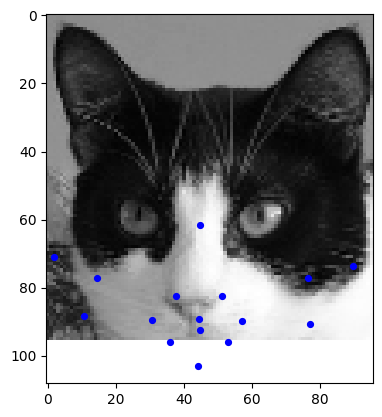

In [103]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = model.predict(test_sample[0])
if BATCH_SIZE == 1:
    sample_image = test_sample[0][0]
    sample_coords = yhat[0]
    
    key_pts = sample_coords*25 + 50
    
    plt.imshow(sample_image, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=70, marker='.', c='b')
    plt.savefig("mixed_5_dropout/foto8.png")
else:
    fig, ax = plt.subplots(ncols=BATCH_SIZE, figsize=(20,20))
    for idx in range(BATCH_SIZE): 
        sample_image = test_sample[0][idx]
        sample_coords = yhat[idx]

        key_pts = sample_coords*25 + 50
        

        ax[idx].imshow(sample_image, cmap='gray')
        ax[idx].scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
        
        

In [30]:
# Save the entire model as a `.keras` zip archive.
model.save('mixed_5_400_epoch_batch_8_with_dropout.keras')

In [31]:
import pickle
with open("hist_loss_mixed_5_with_dropout", "wb") as fp:
    pickle.dump(hist.history['loss'], fp)

with open("hist_val_loss_mixed_5_with_dropout", "wb") as fp:
    pickle.dump(hist.history['val_loss'], fp)

In [32]:
#model = tf.keras.models.load_model('mixed_5_400_epoch_batch_8_no_dropout.keras')

#with open("hist_loss_mixed_5", "rb") as fp:   # Unpickling
#    loss = pickle.load(fp)
#with open("hist_val_loss_mixed_5", "rb") as fp:   # Unpickling
#    val_loss = pickle.load(fp)

<h2>Gráfica de loss function</h2>

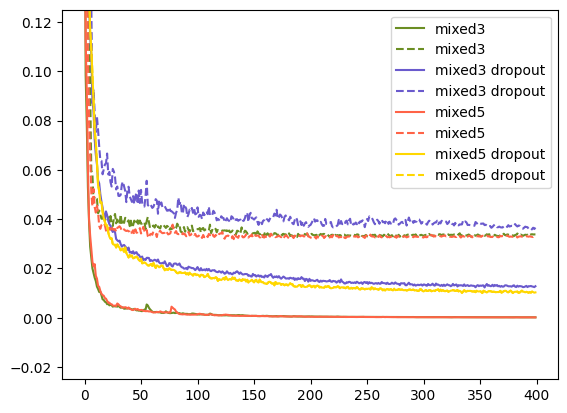

In [132]:
with open("hist_loss_mixed_3", "rb") as fp:   # Unpickling
    m3_loss = pickle.load(fp)
with open("hist_val_loss_mixed_3", "rb") as fp:   # Unpickling
    m3_val_loss = pickle.load(fp)

    
    
    
with open("hist_loss_mixed_3_with_dropout", "rb") as fp:   # Unpickling
    m3_d_loss = pickle.load(fp)
with open("hist_val_loss_mixed_3_with_dropout", "rb") as fp:   # Unpickling
    m3_d_val_loss = pickle.load(fp)

    
    
    
with open("hist_loss_mixed_5", "rb") as fp:   # Unpickling
    m5_loss = pickle.load(fp)
with open("hist_val_loss_mixed_5", "rb") as fp:   # Unpickling
    m5_val_loss = pickle.load(fp)

    
    
    
with open("hist_loss_mixed_5_with_dropout", "rb") as fp:   # Unpickling
    m5_d_loss = pickle.load(fp)
with open("hist_loss_mixed_5_with_dropout", "rb") as fp:   # Unpickling
    m5_d_val_loss = pickle.load(fp)
    
    
    
    


plt.plot(m3_loss, color='olivedrab', label='mixed3')
plt.plot(m3_val_loss, color='olivedrab', linestyle='dashed', label='mixed3')

plt.plot(m3_d_loss, color='slateblue', label='mixed3 dropout')
plt.plot(m3_d_val_loss, color='slateblue', linestyle='dashed', label='mixed3 dropout')

plt.plot(m5_loss, color='tomato', label='mixed5')
plt.plot(m5_val_loss, color='tomato', linestyle='dashed', label='mixed5')

plt.plot(m5_d_loss, color='gold', label='mixed5 dropout')
plt.plot(m5_d_val_loss, color='gold', linestyle='dashed', label='mixed5 dropout')

plt.ylim([-0.025, 0.125])
#plt.suptitle('Loss')
plt.legend()
plt.savefig("loss/loss.png")
plt.show()


